Link to data on kaggle: https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import multiprocessing
n_jobs = multiprocessing.cpu_count() - 2

In [155]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
random_state = 101

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
original_titles = pd.read_csv('titles.csv')
titles = original_titles.copy()

In [6]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


Data consist of title data and some columns referring to rating of title on two diferent sites. Since I want to predict values in one single column I will take mean from tmbd_score and imbd_score and build models predicting this value.  

## Cleaning the data

#### Missing values check

<AxesSubplot:>

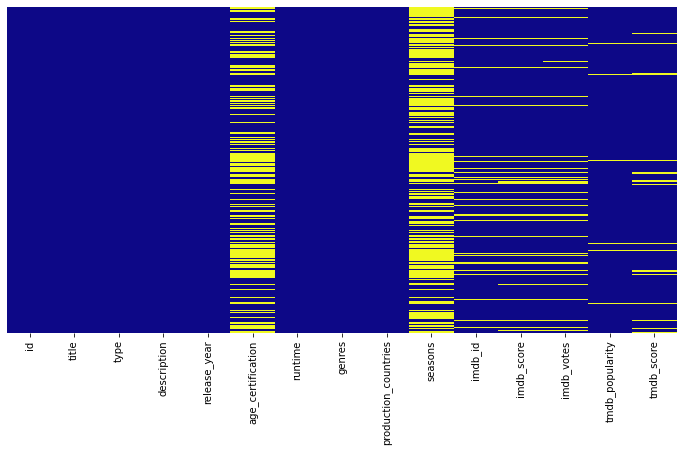

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(titles.isnull(), yticklabels=False, cbar=False, cmap='plasma')

In [8]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5806 non-null   object 
 1   title                 5805 non-null   object 
 2   type                  5806 non-null   object 
 3   description           5788 non-null   object 
 4   release_year          5806 non-null   int64  
 5   age_certification     3196 non-null   object 
 6   runtime               5806 non-null   int64  
 7   genres                5806 non-null   object 
 8   production_countries  5806 non-null   object 
 9   seasons               2047 non-null   float64
 10  imdb_id               5362 non-null   object 
 11  imdb_score            5283 non-null   float64
 12  imdb_votes            5267 non-null   float64
 13  tmdb_popularity       5712 non-null   float64
 14  tmdb_score            5488 non-null   float64
dtypes: float64(5), int64(

#### Drop id, description and imdb_id columns because these are random data from ML standpoint

In [9]:
titles.drop(['id', 'description', 'imdb_id'], axis=1, inplace=True)

In [10]:
titles.columns

Index(['title', 'type', 'release_year', 'age_certification', 'runtime',
       'genres', 'production_countries', 'seasons', 'imdb_score', 'imdb_votes',
       'tmdb_popularity', 'tmdb_score'],
      dtype='object')

#### Convert title column to title_len column

In [11]:
titles['title_len'] = titles['title'].str.len()

In [12]:
titles.dropna(subset=['title'], inplace=True)

In [13]:
titles.drop('title', axis=1, inplace=True)

#### Collect distinct genres and countries sets

In [14]:
from ast import literal_eval

titles['genres'] = titles['genres'].apply(literal_eval)
titles['production_countries'] = titles['production_countries'].apply(literal_eval)

In [15]:
all_genres = []

for title_genres in titles['genres']:
    for genre in title_genres:
        if not genre in all_genres:
            all_genres.append(genre)

In [16]:
all_countries = []

for prod_countries in titles['production_countries']:
    for country in prod_countries:
        if not country in all_countries:
            all_countries.append(country)

#### Create column for each genre and encode genres for each title

In [17]:
for genre in all_genres:
    titles.insert(len(titles.columns), 'genre_' + genre, np.zeros(len(titles)))

In [18]:
for i, row in titles.iterrows():
    for genre in row['genres']:
        titles.loc[i, 'genre_' + genre] = 1

In [19]:
titles.dropna(subset=['genres'], inplace=True)

In [20]:
titles.drop('genres', axis=1, inplace=True)

#### Choose one production country for every title and encode it as number

In [21]:
import random

def pick_one_country(prod_countries):
    if len(prod_countries) == 0:
        return None
    else:
        return random.choice(prod_countries)

In [22]:
titles.insert(len(titles.columns), 'prod_country', np.zeros(len(titles)))

for i, title in titles.iterrows():
    prod_countries = title['production_countries']
    chosen_country = pick_one_country(prod_countries)
    country_id = all_countries.index(chosen_country) if chosen_country in all_countries else None
    titles.at[i, 'prod_country'] = country_id

In [23]:
titles.dropna(subset=['prod_country'], inplace=True)

In [24]:
titles.drop('production_countries', axis=1, inplace=True)

#### Fill seasons value for movies

In [25]:
titles.loc[titles['type'] == 'MOVIE', 'seasons'] = 0

In [26]:
titles.dropna(subset=['seasons'], inplace=True)

#### Encode type as 0 if its value is MOVIE and as 1 otherwise

In [27]:
titles.loc[titles['type'] == 'MOVIE', 'type'] = 0

In [28]:
titles.loc[titles['type'] == 'SHOW', 'type'] = 1

In [29]:
titles.dropna(subset=['type'], inplace=True)

#### Get mean of scores from tmdb and imdb

In [30]:
def get_score_for_title(title):
    imdb_score = title['imdb_score']
    tmdb_score = title['tmdb_score']
    
    if imdb_score is None and tmdb_score is None:
        return None
    
    if imdb_score is None or tmdb_score is None:
        return imdb_score if imdb_score is not None else tmdb_score
    
    return (imdb_score + tmdb_score) / 2

In [31]:
titles['score'] = get_score_for_title(titles)

In [32]:
titles.dropna(subset=['score'], inplace=True)

In [33]:
titles.drop('imdb_score', axis=1, inplace=True)
titles.drop('tmdb_score', axis=1, inplace=True)

#### Encode age_certification as a number

In [34]:
titles['age_certification'].value_counts().index

Index(['TV-MA', 'R', 'PG-13', 'TV-14', 'PG', 'TV-PG', 'TV-Y7', 'G', 'TV-Y',
       'TV-G', 'NC-17'],
      dtype='object')

In [35]:
age_category_mapping = {}

# children
for c in ['PG', 'G', 'TV-Y7', 'TV-Y', 'TV-G']:
    age_category_mapping[c] = 0

# teenagers
for c in ['R', 'TV-14', 'PG-13', 'TV-PG']:
    age_category_mapping[c] = 1

# adults
for c in ['TV-MA', 'NC-17']:
    age_category_mapping[c] = 2

In [36]:
titles['age_certification'] = titles['age_certification'].map(age_category_mapping)

#### Summarizing cleaning done as far

In [37]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4957 entries, 1 to 5798
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 4957 non-null   object 
 1   release_year         4957 non-null   int64  
 2   age_certification    2877 non-null   float64
 3   runtime              4957 non-null   int64  
 4   seasons              4957 non-null   float64
 5   imdb_votes           4943 non-null   float64
 6   tmdb_popularity      4957 non-null   float64
 7   title_len            4957 non-null   float64
 8   genre_documentation  4957 non-null   float64
 9   genre_crime          4957 non-null   float64
 10  genre_drama          4957 non-null   float64
 11  genre_comedy         4957 non-null   float64
 12  genre_fantasy        4957 non-null   float64
 13  genre_horror         4957 non-null   float64
 14  genre_european       4957 non-null   float64
 15  genre_thriller       4957 non-null   f

In [38]:
# Some missing imdb_votes left
titles.dropna(subset=['imdb_votes'], inplace=True)

#### Filling missing values in age_certification using simple SVM model

In [39]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [40]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
        
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [41]:
X = titles.drop('age_certification', axis=1)[titles['age_certification'].notnull()]
y = titles[titles['age_certification'].notnull()]['age_certification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [42]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
kfold = StratifiedKFold(n_splits=5)

In [44]:
param_grid = {
    'C': [10, 100, 1000, 10000, 100000],
    'gamma': [0.00001, 0.0001, 0.001, 0.01],
}

In [45]:
grid = GridSearchCV(SVC(), param_grid, cv=kfold, n_jobs=n_jobs)

In [46]:
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=10,
             param_grid={'C': [10, 100, 1000, 10000, 100000],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01]})

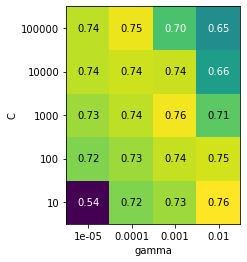

In [47]:
results = pd.DataFrame(grid.cv_results_)
scores = np.array(results.mean_test_score).reshape(5, 4)
heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'], 
        ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

In [48]:
grid.best_params_

{'C': 10, 'gamma': 0.01}

In [49]:
age_cert_estimator = grid.best_estimator_

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
accuracy_score(y_test, age_cert_estimator.predict(X_test))

0.7549361207897793

In [52]:
without_age_cert = titles[titles['age_certification'].isnull()].drop('age_certification', axis=1)
predictions = age_cert_estimator.predict(without_age_cert)

C:\conda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [53]:
titles.loc[titles['age_certification'].isnull(), 'age_certification'] = predictions

In [54]:
# One last step: one hot encode age_certification

In [55]:
cert_to_age_cat = { 0: 'children', 1: 'teenagers', 2: 'adults' }

In [56]:
age_cert_dummies = pd.get_dummies(titles['age_certification'].map(cert_to_age_cat), 
                                  drop_first=True, prefix='cert')

In [57]:
titles = pd.concat((titles, age_cert_dummies), axis=1)

In [58]:
titles.drop('age_certification', axis=1, inplace=True)

#### Summarizing the cleanup

In [59]:
titles.columns

Index(['type', 'release_year', 'runtime', 'seasons', 'imdb_votes',
       'tmdb_popularity', 'title_len', 'genre_documentation', 'genre_crime',
       'genre_drama', 'genre_comedy', 'genre_fantasy', 'genre_horror',
       'genre_european', 'genre_thriller', 'genre_action', 'genre_music',
       'genre_romance', 'genre_family', 'genre_western', 'genre_war',
       'genre_animation', 'genre_history', 'genre_scifi', 'genre_reality',
       'genre_sport', 'prod_country', 'score', 'cert_children',
       'cert_teenagers'],
      dtype='object')

In [60]:
columns_order = ['type', 'title_len', 'release_year', 'runtime', 'seasons', 
       'imdb_votes', 'tmdb_popularity', 'genre_documentation', 'genre_crime',
       'genre_drama', 'genre_comedy', 'genre_fantasy', 'genre_horror',
       'genre_european', 'genre_thriller', 'genre_action', 'genre_music',
       'genre_romance', 'genre_family', 'genre_western', 'genre_war',
       'genre_animation', 'genre_history', 'genre_scifi', 'genre_reality',
       'genre_sport', 'prod_country', 'cert_children', 'cert_teenagers', 'score']

titles = titles.reindex(columns=columns_order)

<AxesSubplot:>

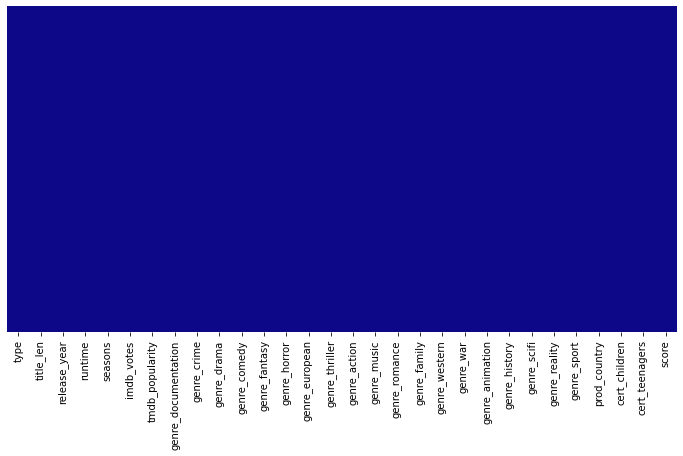

In [61]:
plt.figure(figsize=(12, 6))
sns.heatmap(titles.isnull(), yticklabels=False, cbar=False, cmap='plasma')

In [62]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4943 entries, 1 to 5798
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 4943 non-null   object 
 1   title_len            4943 non-null   float64
 2   release_year         4943 non-null   int64  
 3   runtime              4943 non-null   int64  
 4   seasons              4943 non-null   float64
 5   imdb_votes           4943 non-null   float64
 6   tmdb_popularity      4943 non-null   float64
 7   genre_documentation  4943 non-null   float64
 8   genre_crime          4943 non-null   float64
 9   genre_drama          4943 non-null   float64
 10  genre_comedy         4943 non-null   float64
 11  genre_fantasy        4943 non-null   float64
 12  genre_horror         4943 non-null   float64
 13  genre_european       4943 non-null   float64
 14  genre_thriller       4943 non-null   float64
 15  genre_action         4943 non-null   f

## Creating ML models
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net Regression
- Random Forest Regressor
- Neural Network

In [63]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [64]:
# Let's start with splitting and scaling the data
model_results = pd.DataFrame(columns=['name', 'mae', 'mse', 'rmse'])

In [65]:
def append_result(name, true_values, predictions):
    row = pd.DataFrame([[
        name,
        mean_absolute_error(true_values, predictions),
        mean_squared_error(true_values, predictions),
        np.sqrt(mean_squared_error(true_values, predictions))
    ]], columns='name mae mse rmse'.split())
    global model_results
    model_results = pd.concat([model_results, row])

In [66]:
X = titles.drop('score', axis=1)
y = titles['score']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [68]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
X_train

array([[0.        , 0.0776699 , 0.92753623, ..., 0.04716981, 0.        ,
        1.        ],
       [1.        , 0.08737864, 0.94202899, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.14563107, 0.97101449, ..., 0.12264151, 0.        ,
        1.        ],
       ...,
       [0.        , 0.06796117, 0.7826087 , ..., 0.00943396, 0.        ,
        1.        ],
       [1.        , 0.37864078, 0.92753623, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11650485, 0.97101449, ..., 0.        , 0.        ,
        1.        ]])

### Linear Regression

In [70]:
pipe_1 = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2)), 
    ('scaler', StandardScaler()),
    ('classifier', LinearRegression())
])

In [71]:
param_grid_1 = {'polynomial__degree': [1, 2]}

In [72]:
grid_1 = GridSearchCV(pipe_1, param_grid_1, verbose=10, n_jobs=n_jobs)

In [73]:
grid_1.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', LinearRegression())]),
             n_jobs=10, param_grid={'polynomial__degree': [1, 2]}, verbose=10)

In [74]:
grid_1.best_params_

{'polynomial__degree': 1}

In [75]:
append_result('Linear Regression', y_test, grid_1.predict(X_test))

### Ridge Regression

In [76]:
pipe_2 = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2)), 
    ('scaler', StandardScaler()),
    ('classifier', Ridge())
])

In [77]:
param_grid_2 = {
    'polynomial__degree': [1, 2, 3], 
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

In [78]:
grid_2 = GridSearchCV(pipe_2, param_grid_2, verbose=10, n_jobs=n_jobs)

In [79]:
grid_2.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', Ridge())]),
             n_jobs=10,
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                               100],
                         'polynomial__degree': [1, 2, 3]},
             verbose=10)

In [80]:
grid_2.best_params_

{'classifier__alpha': 100, 'polynomial__degree': 2}

In [81]:
append_result('Ridge Regression', y_test, grid_2.predict(X_test))

### Lasso Regression

In [82]:
pipe_3 = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2)), 
    ('scaler', StandardScaler()),
    ('classifier', Lasso())
])

In [83]:
param_grid_3 = {
    'polynomial__degree': [1, 2, 3], 
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

In [84]:
grid_3 = GridSearchCV(pipe_3, param_grid_3, verbose=10, n_jobs=n_jobs, )

In [85]:
grid_3.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', Lasso())]),
             n_jobs=10,
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                               100],
                         'polynomial__degree': [1, 2, 3]},
             verbose=10)

In [86]:
grid_3.best_params_

{'classifier__alpha': 0.01, 'polynomial__degree': 2}

In [87]:
append_result('Lasso Regression', y_test, grid_3.predict(X_test))

### Elastic Net

In [88]:
pipe_4 = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2)), 
    ('scaler', StandardScaler()),
    ('classifier', ElasticNet())
])

In [89]:
param_grid_4 = {
    'polynomial__degree': [1, 2, 3], 
    'classifier__alpha': [0.001, 0.01, 0.1, 1],
    'classifier__l1_ratio': [0.01, 0.05, 0.1, 0.2]
}

In [90]:
grid_4 = GridSearchCV(pipe_4, param_grid_4, verbose=10, n_jobs=n_jobs)

In [91]:
grid_4.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=Pipeline(steps=[('polynomial', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('classifier', ElasticNet())]),
             n_jobs=10,
             param_grid={'classifier__alpha': [0.001, 0.01, 0.1, 1],
                         'classifier__l1_ratio': [0.01, 0.05, 0.1, 0.2],
                         'polynomial__degree': [1, 2, 3]},
             verbose=10)

In [92]:
grid_4.best_params_

{'classifier__alpha': 0.1,
 'classifier__l1_ratio': 0.05,
 'polynomial__degree': 2}

In [93]:
append_result('Elastic Net Regression', y_test, grid_4.predict(X_test))

In [94]:
model_results

,name,mae,mse,rmse
0,Linear Regression,0.629752,0.682939,0.826401
0,Ridge Regression,0.619739,0.666463,0.816372
0,Lasso Regression,0.606533,0.64384,0.802396
0,Elastic Net Regression,0.610074,0.649895,0.80616


### RandomForestRegressor

In [95]:
pipe_5 = Pipeline([
    ('classifier', RandomForestRegressor())
])

In [96]:
from random import randint

param_grid_5 = {
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__n_estimators': [500, 1000, 1500],
    'classifier__max_depth': [30, 50, 100]
}

In [97]:
grid_5 = GridSearchCV(pipe_5, param_grid_5, verbose=10, n_jobs=n_jobs)

In [98]:
grid_5.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        RandomForestRegressor())]),
             n_jobs=10,
             param_grid={'classifier__max_depth': [30, 50, 100],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__n_estimators': [500, 1000, 1500]},
             verbose=10)

In [99]:
grid_5.best_params_

{'classifier__max_depth': 100,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 1000}

In [100]:
append_result('Random Forest Regressor', y_test, grid_5.predict(X_test))

### Comparing models trained so far

In [101]:
model_results

,name,mae,mse,rmse
0,Linear Regression,0.629752,0.682939,0.826401
0,Ridge Regression,0.619739,0.666463,0.816372
0,Lasso Regression,0.606533,0.64384,0.802396
0,Elastic Net Regression,0.610074,0.649895,0.80616
0,Random Forest Regressor,0.555338,0.550929,0.742246


<AxesSubplot:title={'center':'Models rmse comparison'}, xlabel='rmse', ylabel='name'>

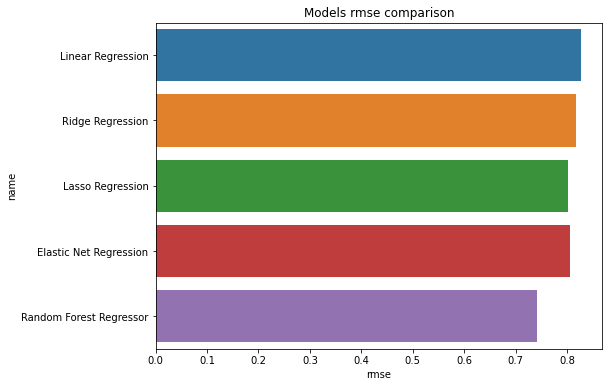

In [102]:
plt.figure(figsize=(8, 6))
plt.title('Models rmse comparison')
sns.barplot(data=model_results, x='rmse', y='name')

**Clearly Random Forest Regressor provides better estimations than others because it has lowest rmse value**

### Neural Network

In [103]:
import tensorflow as tf
from scipy.stats import uniform, randint
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.callbacks import History, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD

In [104]:
def create_model(batch_size, epochs, learn_rate, 
                 momentum, activation, dropout_rate, neurons):
    model = Sequential()
    
    for neurons_nb in neurons:
        model.add(Dense(neurons_nb, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = RMSprop(learning_rate=learn_rate, momentum=momentum)
    
    model.compile(optimizer=optimizer,
             loss='mean_squared_error',
             metrics=['mean_squared_error'])
    
    return model

In [105]:
nn_param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [100],
    'learn_rate': [0.0001, 0.0005, 0.001],
    'momentum': [0.2],
    'activation': ['relu'],
    'dropout_rate': [0.2],
    'neurons': [[500, 200, 100, 50]],
}

In [106]:
nn_model = KerasRegressor(build_fn=create_model)

C:\Users\Kamil\AppData\Local\Temp\ipykernel_18420\1367771281.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasRegressor(build_fn=create_model)


In [107]:
search = GridSearchCV(estimator=nn_model, param_grid=nn_param_grid, 
                      n_jobs=n_jobs, cv=5, verbose=10, return_train_score=True)

In [108]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/100
173/173 [==============================] - 1s 3ms/step - loss: 13.4121 - mean_squared_error: 13.4121
Epoch 2/100
173/173 [==============================] - 0s 3ms/step - loss: 2.5808 - mean_squared_error: 2.5808
Epoch 3/100
173/173 [==============================] - 0s 3ms/step - loss: 2.1886 - mean_squared_error: 2.1886
Epoch 4/100
173/173 [==============================] - 0s 3ms/step - loss: 2.0318 - mean_squared_error: 2.0318
Epoch 5/100
173/173 [==============================] - 0s 3ms/step - loss: 1.8159 - mean_squared_error: 1.8159
Epoch 6/100
173/173 [==============================] - 0s 3ms/step - loss: 1.7501 - mean_squared_error: 1.7501
Epoch 7/100
173/173 [==============================] - 0s 3ms/step - loss: 1.7527 - mean_squared_error: 1.7527
Epoch 8/100
173/173 [==============================] - 0s 3ms/step - loss: 1.6626 - mean_squared_error: 1.6626
Epoch 9/100
173/173 [=============================

173/173 [==============================] - 0s 3ms/step - loss: 1.1547 - mean_squared_error: 1.1547
Epoch 74/100
173/173 [==============================] - 1s 3ms/step - loss: 1.1843 - mean_squared_error: 1.1843
Epoch 75/100
173/173 [==============================] - 1s 3ms/step - loss: 1.1613 - mean_squared_error: 1.1613
Epoch 76/100
173/173 [==============================] - 1s 3ms/step - loss: 1.1679 - mean_squared_error: 1.1679
Epoch 77/100
173/173 [==============================] - 0s 3ms/step - loss: 1.1749 - mean_squared_error: 1.1749
Epoch 78/100
173/173 [==============================] - 0s 2ms/step - loss: 1.1713 - mean_squared_error: 1.1713
Epoch 79/100
173/173 [==============================] - 0s 3ms/step - loss: 1.1946 - mean_squared_error: 1.1946
Epoch 80/100
173/173 [==============================] - 0s 2ms/step - loss: 1.1813 - mean_squared_error: 1.1813
Epoch 81/100
173/173 [==============================] - 0s 3ms/step - loss: 1.2000 - mean_squared_error: 1.2000
Epoch

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001A30BFB0400>,
             n_jobs=10,
             param_grid={'activation': ['relu'], 'batch_size': [10, 20, 30],
                         'dropout_rate': [0.2], 'epochs': [100],
                         'learn_rate': [0.0001, 0.0005, 0.001],
                         'momentum': [0.2], 'neurons': [[500, 200, 100, 50]]},
             return_train_score=True, verbose=10)

In [109]:
search.best_params_

{'activation': 'relu',
 'batch_size': 20,
 'dropout_rate': 0.2,
 'epochs': 100,
 'learn_rate': 0.0001,
 'momentum': 0.2,
 'neurons': [500, 200, 100, 50]}

Now train model with best parameters again but with more epochs

In [110]:
best_params = search.best_params_
nn = create_model(**best_params)

In [111]:
history = History()
early_stopping = EarlyStopping(patience=100)

nn.fit(np.asarray(X_train).astype(np.float32), y_train, 
       epochs=5000, batch_size=best_params['batch_size'],
       validation_data=(np.asarray(X_test).astype(np.float32), y_test),
       callbacks=[history, early_stopping])

Epoch 1/5000
173/173 [==============================] - 1s 4ms/step - loss: 12.5898 - mean_squared_error: 12.5898 - val_loss: 1.1907 - val_mean_squared_error: 1.1907
Epoch 2/5000
173/173 [==============================] - 1s 3ms/step - loss: 2.3437 - mean_squared_error: 2.3437 - val_loss: 0.9518 - val_mean_squared_error: 0.9518
Epoch 3/5000
173/173 [==============================] - 1s 3ms/step - loss: 2.0128 - mean_squared_error: 2.0128 - val_loss: 0.8480 - val_mean_squared_error: 0.8480
Epoch 4/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.9335 - mean_squared_error: 1.9335 - val_loss: 0.8477 - val_mean_squared_error: 0.8477
Epoch 5/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.9104 - mean_squared_error: 1.9104 - val_loss: 0.9040 - val_mean_squared_error: 0.9040
Epoch 6/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.7549 - mean_squared_error: 1.7549 - val_loss: 0.7287 - val_mean_squared_error: 0.7287
Epoch 7/5000
1

Epoch 51/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.1792 - mean_squared_error: 1.1792 - val_loss: 0.6912 - val_mean_squared_error: 0.6912
Epoch 52/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.1835 - mean_squared_error: 1.1835 - val_loss: 0.8447 - val_mean_squared_error: 0.8447
Epoch 53/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.1722 - mean_squared_error: 1.1722 - val_loss: 0.6717 - val_mean_squared_error: 0.6717
Epoch 54/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.1728 - mean_squared_error: 1.1728 - val_loss: 0.7157 - val_mean_squared_error: 0.7157
Epoch 55/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.1149 - mean_squared_error: 1.1149 - val_loss: 0.6975 - val_mean_squared_error: 0.6975
Epoch 56/5000
173/173 [==============================] - 1s 3ms/step - loss: 1.0921 - mean_squared_error: 1.0921 - val_loss: 0.6748 - val_mean_squared_error: 0.6748
Epoch 57/5

173/173 [==============================] - 1s 4ms/step - loss: 1.0098 - mean_squared_error: 1.0098 - val_loss: 0.7089 - val_mean_squared_error: 0.7089
Epoch 101/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.9869 - mean_squared_error: 0.9869 - val_loss: 0.7294 - val_mean_squared_error: 0.7294
Epoch 102/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.9791 - mean_squared_error: 0.9791 - val_loss: 0.6913 - val_mean_squared_error: 0.6913
Epoch 103/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.9809 - mean_squared_error: 0.9809 - val_loss: 0.7347 - val_mean_squared_error: 0.7347
Epoch 104/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.9681 - mean_squared_error: 0.9681 - val_loss: 0.6945 - val_mean_squared_error: 0.6945
Epoch 105/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.9795 - mean_squared_error: 0.9795 - val_loss: 0.6796 - val_mean_squared_error: 0.6796
Epoch 106/5000
173/

173/173 [==============================] - 1s 3ms/step - loss: 0.8799 - mean_squared_error: 0.8799 - val_loss: 0.7190 - val_mean_squared_error: 0.7190
Epoch 150/5000
173/173 [==============================] - 1s 3ms/step - loss: 0.8760 - mean_squared_error: 0.8760 - val_loss: 0.6936 - val_mean_squared_error: 0.6936
Epoch 151/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.8735 - mean_squared_error: 0.8735 - val_loss: 0.6871 - val_mean_squared_error: 0.6871
Epoch 152/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.8625 - mean_squared_error: 0.8625 - val_loss: 0.6874 - val_mean_squared_error: 0.6874
Epoch 153/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.8336 - mean_squared_error: 0.8336 - val_loss: 0.7549 - val_mean_squared_error: 0.7549
Epoch 154/5000
173/173 [==============================] - 1s 4ms/step - loss: 0.8652 - mean_squared_error: 0.8652 - val_loss: 0.7225 - val_mean_squared_error: 0.7225
Epoch 155/5000
173/

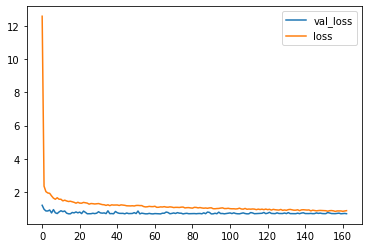

In [112]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()

In [113]:
append_result('Neural Network', nn.predict(X_test), y_test)

47/47 [==============================] - 0s 2ms/step


In [114]:
model_results

,name,mae,mse,rmse
0,Linear Regression,0.629752,0.682939,0.826401
0,Ridge Regression,0.619739,0.666463,0.816372
0,Lasso Regression,0.606533,0.64384,0.802396
0,Elastic Net Regression,0.610074,0.649895,0.80616
0,Random Forest Regressor,0.555338,0.550929,0.742246
0,Neural Network,0.628043,0.683894,0.826979


**Suprisingly Neural Network predictions are worse than Random Forest Regressor**

The best model in this case is ensemble of random trees. Its rmse is approximately 0.77 which means that we can expect the model to miss the correct title score by 0.77.

In [166]:
random_forest = grid_5.best_estimator_

In [167]:
neural_network = nn

Let's predict score for my favourite movie: Joker from 2019

47/47 [==============================] - 0s 2ms/step


<AxesSubplot:xlabel='score'>

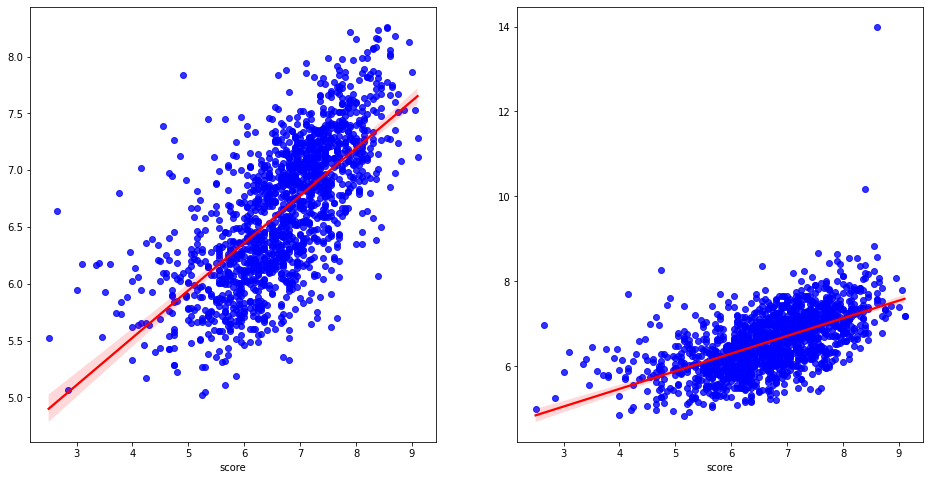

In [168]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

sns.regplot(y_test, random_forest.predict(X_test), ax=axes[0], 
            scatter_kws={"color": "blue"}, line_kws={"color": "red"})

sns.regplot(y_test, neural_network.predict(X_test), ax=axes[1],
            scatter_kws={"color": "blue"}, line_kws={"color": "red"})

There is no api to download popularity metric from IMDB for given movie, but 28 is close to popularities of comparable movies

In [199]:
joker = np.array([0, 5, 2019, 122, 0, 1203710, 28, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1, -1)
scaled_joker = scaler.transform(joker)

In [200]:
random_forest.predict(scaled_joker)

array([5.86235])

In [201]:
neural_network.predict(scaled_joker)

1/1 [==============================] - 0s 20ms/step


array([[8.599709]], dtype=float32)

Correct value is (8.2 + 8.4) / 2 = 8.3

To sum up it seems like although NN has worse metrics it is better predictor for real world queries.